In [21]:
import sys
sys.path.append('..')
from helpers import util
import cv2
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import os


[[0 0 0]
 [1 0 0]
 [0 1 0]
 [0 0 1]]
../../data/camera_calibration_frames_redo/to_copy_local_manual/1_0.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/1_1.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/1_2.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/1_3.npz True


<IPython.core.display.Javascript object>


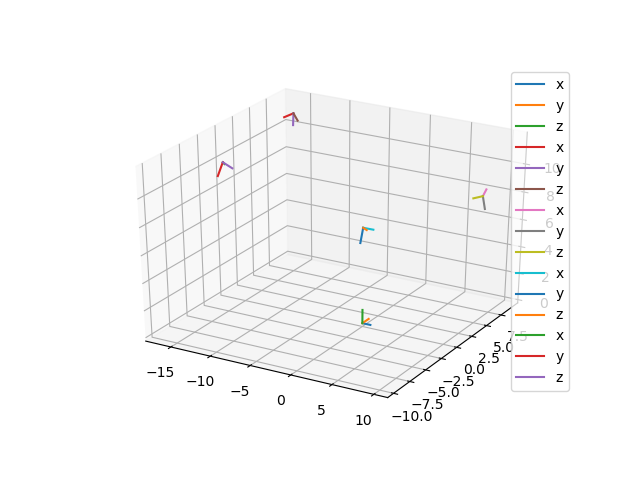

../../data/camera_calibration_frames_redo/to_copy_local_manual/2_0.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/2_1.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/2_2.npz True
../../data/camera_calibration_frames_redo/to_copy_local_manual/2_3.npz True


<IPython.core.display.Javascript object>


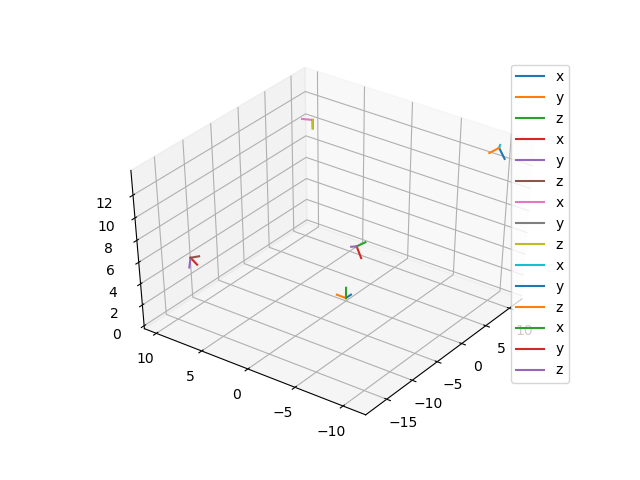

In [52]:
# format 4x3 [origin,xaxis,yaxis,zaxis]
def plot_as_axes(ax,three_pts):
    ax.plot(three_pts[[0,1],0],three_pts[[0,1],1],three_pts[[0,1],2],label = 'x')
    ax.plot(three_pts[[0,2],0],three_pts[[0,2],1],three_pts[[0,2],2],label = 'y')
    ax.plot(three_pts[[0,3],0],three_pts[[0,3],1],three_pts[[0,3],2],label = 'z')

def get_cam_rot_t(in_dir, cell_num, cam_range):
    to_ret = []
    for cam in cam_range:
        in_file = os.path.join(in_dir, '_'.join([cell_num,cam])+'.npz')
        print (in_file, os.path.exists(in_file))
        loaded = np.load(in_file)
        [rvec, tvec] = [loaded[key] for key in ['rvec','tvec']]
        rot, jacob = cv2.Rodrigues(rvec)
        camera_pos = np.matmul(-rot.T,tvec) 
        to_ret.append((camera_pos, rot, tvec))
    return to_ret
        
    

    
def main():
    pts = [[0,0,0],[1,0,0],[0,1,0],[0,0,1]]
    pts = np.array(pts)
    print (pts)
    
    in_dir = '../../data/camera_calibration_frames_redo/to_copy_local_manual'
    cell_num = '1'
    cam_range = [str(val) for val in range(4)]
    for cell_num in ['1','2']:
        cam_rot_t = get_cam_rot_t(in_dir, cell_num, cam_range)

        new_axis_all = []
        for cam_pos, rot, tvec in cam_rot_t:
            pts_new = (pts.T*10)-tvec
            camera_axis = np.matmul(rot.T,pts_new).T
            camera_axis = camera_axis/10
            new_axis_all.append(camera_axis)

        fig = plt.figure()
        ax = fig.gca(projection='3d')
        ax.set_aspect('equal')
        plot_as_axes(ax,pts)
        for camera_axis in new_axis_all:
            plot_as_axes(ax,camera_axis)
        ax.legend()
        plt.show()
#         print (pts_new)
#         print (cam_pos.shape, pts.shape)
    
#     rot,jacob = cv2.Rodrigues(rvec)
#     camera_pos = np.matmul(-rot.T,tvec)




#     mpl.rcParams['legend.fontsize'] = 10

#     fig = plt.figure()

#     ax = fig.gca(projection='3d')
#     theta = np.linspace(-4 * np.pi, 4 * np.pi, 100)
#     z = np.linspace(-2, 2, 100)
#     r = z**2 + 1
#     x = r * np.sin(theta)
#     y = r * np.cos(theta)

#     plot_as_axes(ax, pts)
#     # ax.plot(x, y, z, label='parametric curve')
#     ax.legend()
#     # ax('equal')
#     plt.show()

main()
